In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [2]:
def clean_text(text):
    # Remove <br> tags
    text = re.sub(r'<br\s*/?>', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(["mr", "ms", "mrs", "dr", "film", "movie", "really", "one"])  # Add more stop words as needed 
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Remove 1-2 length words
    text = ' '.join(word for word in text.split() if len(word) > 2)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [3]:
def load_data(path = "IMDB Dataset.csv"):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(path)

    # Apply the clean_text and word2vec function to the 'review' column
    df['review'] = df['review'].apply(clean_text)

    # Get the cleaned review and sentiment as numpy arrays
    review = np.array(df['review'])
    sentiment = np.array(df['sentiment'])
    
    # Convert sentiment labels to 0s and 1s
    sentiment = np.where(sentiment == 'positive', 1, 0)
    
    return review, sentiment

review, sentiment= load_data()

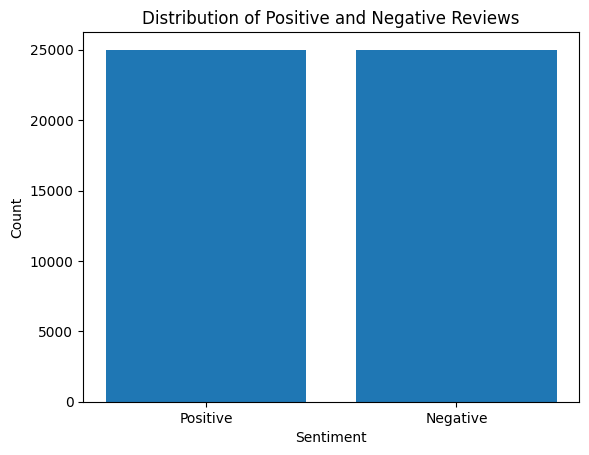

In [4]:
# Count the number of positive and negative reviews
positive_count = np.sum(sentiment == 1)
negative_count = np.sum(sentiment == 0)

# Plot the distribution of positive and negative reviews
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.bar(labels, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Reviews')
plt.show()
del positive_count, negative_count, labels, counts

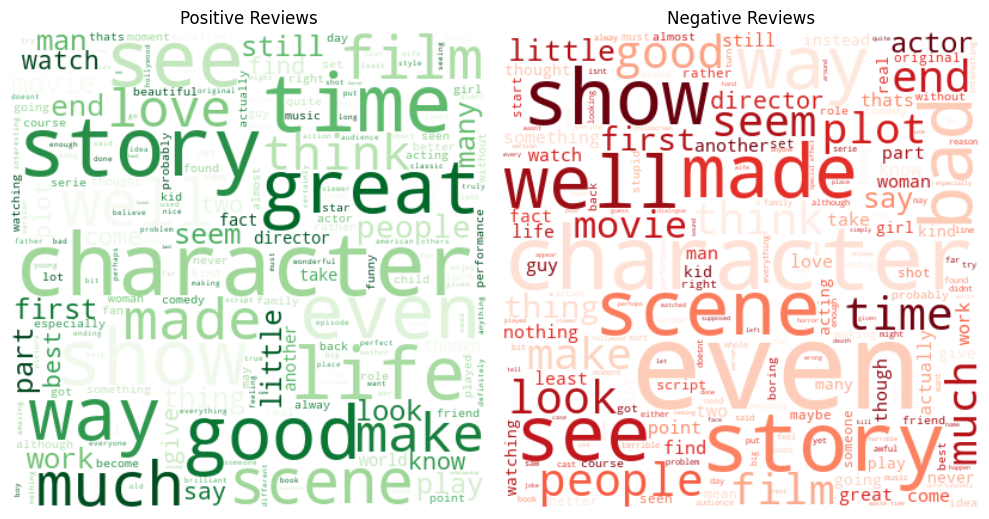

In [5]:
# Separate positive and negative reviews
positive_reviews = ' '.join(review[sentiment == 1])
negative_reviews = ' '.join(review[sentiment == 0])

# Generate word clouds for positive and negative reviews
positive_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Greens').generate(positive_reviews)
negative_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

# Plot side-by-side subplots for positive and negative word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Reviews')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Reviews')
axes[1].axis('off')

plt.tight_layout()
plt.show()
del positive_wordcloud  , negative_wordcloud

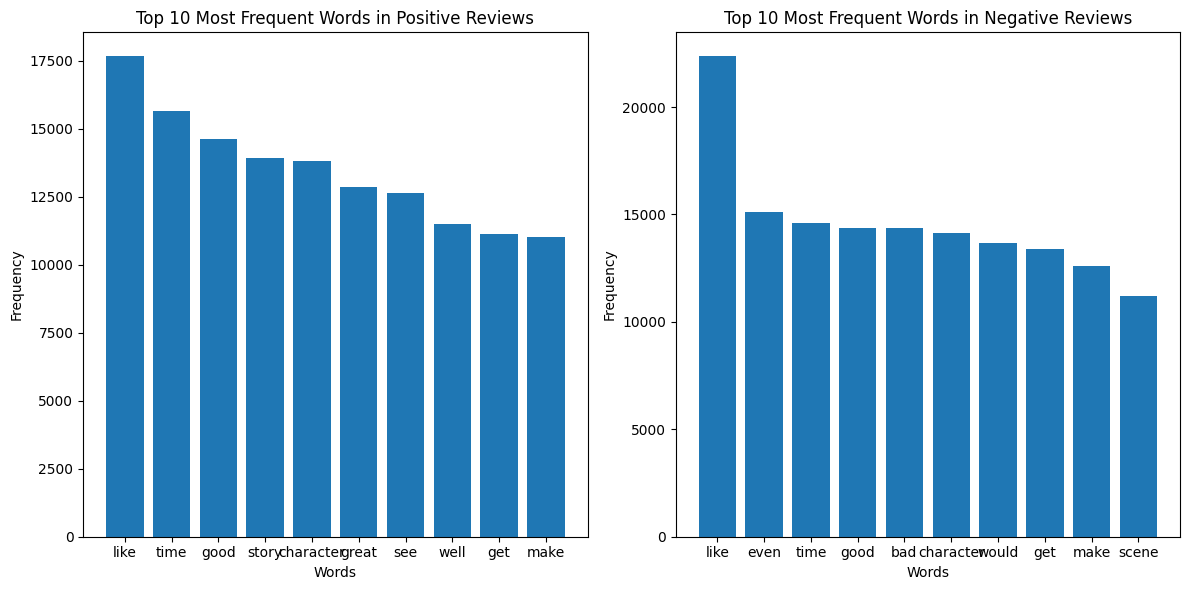

In [ ]:
# Split the positive and negative reviews into individual words
positive_words = positive_reviews.split()
negative_words = negative_reviews.split()

# Count the frequency of each word in positive and negative reviews
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Select the top N most frequent words for positive and negative reviews
top_n = 10  # Change this value to select a different number of words
top_positive_words = positive_word_counts.most_common(top_n)
top_negative_words = negative_word_counts.most_common(top_n)

# Extract the words and their frequencies for positive and negative reviews
positive_labels = [word[0] for word in top_positive_words]
positive_frequencies = [word[1] for word in top_positive_words]

negative_labels = [word[0] for word in top_negative_words]
negative_frequencies = [word[1] for word in top_negative_words]

# Plot side-by-side bar charts for positive and negative word frequencies
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(positive_labels, positive_frequencies)
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top {} Most Frequent Words in Positive Reviews'.format(top_n))

axes[1].bar(negative_labels, negative_frequencies)
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top {} Most Frequent Words in Negative Reviews'.format(top_n))

plt.tight_layout()
plt.show()
del positive_reviews, negative_reviews, positive_words, negative_words, positive_word_counts, negative_word_counts

In [9]:
def preprocessing_data(review, word2vec_model_path = "Weights/word2vec_model.bin"):
    # Tokenize the text data
    tokenized_reviews = [review.split() for review in review]

    # # Train Word2Vec model on tokenized reviews
    # word2vec_model = Word2Vec(tokenized_reviews, vector_size=200, window=5, min_count=1, workers=4)

    # # Save Word2Vec model
    # word2vec_model.save("Weights/word2vec_model.bin")
    
    # Load Word2Vec model
    word2vec_model = Word2Vec.load(word2vec_model_path)

    # Convert text to word embeddings
    embedded_reviews = []
    for tokens in tokenized_reviews:
        embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
        embedded_reviews.append(embeddings)

    # Obtain fixed-size representation by averaging
    averaged_reviews = []
    for embeddings in embedded_reviews:
        averaged_reviews.append(np.mean(embeddings, axis=0))

    # Convert to numpy array
    averaged_reviews = np.array(averaged_reviews)
    
    return averaged_reviews

reviews = preprocessing_data(review)

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(reviews, sentiment, test_size=0.3, stratify = sentiment)
y_cat_train = to_categorical(y_train,2)
y_cat_test = to_categorical(y_test,2) 
del reviews, review, sentiment

In [6]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, PReLU
from keras.initializers import RandomUniform

model = Sequential()

model.add(Input(200))

model.add(Dense(256))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  # Random uniform initialization
model.add(Dense(512))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))
model.add(Dense(256))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))
model.add(Dense(128))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  
model.add(Dense(64))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  
model.add(Dense(32))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  

model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
model.load_weights("Weights/Sentiment Analysis Dense.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51456     
                                                                 
 p_re_lu (PReLU)             (None, 256)               256       
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 p_re_lu_1 (PReLU)           (None, 512)               512       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 p_re_lu_2 (PReLU)           (None, 256)               256       
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=5, 
    mode='max'
)

In [8]:
model.fit(x_train, y_cat_train,
          epochs = 100,
          verbose = 1,
          validation_data = (x_test, y_cat_test),
          callbacks = [early_stopping])

Epoch 1/100
1094/1094 [==============================] - 11s 9ms/step - loss: 0.1761 - accuracy: 0.9475 - val_loss: 0.1538 - val_accuracy: 0.9534
Epoch 2/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1471 - accuracy: 0.9531 - val_loss: 0.1635 - val_accuracy: 0.9471
Epoch 3/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1290 - accuracy: 0.9583 - val_loss: 0.1775 - val_accuracy: 0.9445
Epoch 4/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1146 - accuracy: 0.9626 - val_loss: 0.1795 - val_accuracy: 0.9445
Epoch 5/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.1024 - accuracy: 0.9663 - val_loss: 0.1850 - val_accuracy: 0.9428
Epoch 6/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0903 - accuracy: 0.9711 - val_loss: 0.2483 - val_accuracy: 0.9407
Epoch 7/100
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0805 - accuracy: 0.9735 - val_loss: 0.1949 - val_a

In [9]:
#Save model
model.save('Weights/Sentiment Analysis Dense.h5')  

In [10]:
def word2vec(review, word2vec_model_path="Weights/word2vec_model.bin"):
    # Tokenize the text data
    tokenized_reviews = review.split()  # Split the string into tokens

    # Load Word2Vec model
    word2vec_model = Word2Vec.load(word2vec_model_path)

    # Convert text to word embeddings
    embeddings = [word2vec_model.wv[word] for word in tokenized_reviews if word in word2vec_model.wv]

    # Obtain fixed-size representation by averaging
    averaged_reviews = np.mean(embeddings, axis=0)

    # Convert to numpy array
    averaged_reviews = np.array([averaged_reviews])
    
    return averaged_reviews

In [11]:
summary = ["Negative","Positive"]
text = input()
text = clean_text(text)
text = word2vec(text)
text = text.reshape(1, 200)
result = np.argmax(model.predict(text))
summary[result]

1/1 [==============================] - 0s 148ms/step


'Positive'